In [126]:
pip install yfinance pandas_datareader requests meteostat arch pymc3 graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [135]:
!pip uninstall arviz -y

Found existing installation: arviz 0.20.0
Uninstalling arviz-0.20.0:
  Successfully uninstalled arviz-0.20.0


# Collect Asset Price Data

In [97]:
import yfinance as yf
import pandas as pd

# List of selected energy securities
tickers = ['NEE', 'BEP', 'FSLR', 'XOM', 'CVX', 'COP', 'ICLN', 'XLE', 'ENB', 'SRE']

# Define the benchmark (S&P 500 - SPY)
benchmark_ticker = 'SPY'

# Define the futures contracts to pull (Crude Oil - CL=F, Natural Gas - NG=F)
futures_tickers = ['CL=F', 'NG=F']

# Add inverse ETF for hedging (ProShares Short S&P 500 - SH)
inverse_etf = ['SH']

# Combine security tickers with benchmark tickers, futures tickers, and inverse ETFs
all_tickers = tickers + [benchmark_ticker] + futures_tickers + inverse_etf

# Define the time period (6 months of data)
start_date = '2024-04-01'
end_date = '2024-10-01'

# Download historical data for the selected tickers (including benchmarks, futures, and inverse ETF)
data = yf.download(all_tickers, start=start_date, end=end_date, group_by='ticker', auto_adjust=True)

# Check if 'Adj Close' exists, otherwise use 'Close'
if 'Adj Close' in data.columns.levels[1]:
    adj_close = data.xs('Adj Close', axis=1, level=1)
else:
    adj_close = data.xs('Close', axis=1, level=1)

# Save the price data to a CSV file for analysis
adj_close.to_csv('price_data_6_months.csv')

# Calculate returns
returns = adj_close.pct_change()

# Display the first few rows of the resulting DataFrame
print(returns.head())

[*********************100%%**********************]  14 of 14 completed

Ticker           XOM       COP       XLE        SH      FSLR       BEP  \
Date                                                                     
2024-04-01       NaN       NaN       NaN       NaN       NaN       NaN   
2024-04-02  0.019574  0.015465  0.013984  0.007576 -0.027346 -0.004325   
2024-04-03  0.000168  0.007347  0.006844 -0.001671 -0.002632 -0.018245   
2024-04-04  0.003521  0.000912 -0.000618  0.013389  0.028369  0.011062   
2024-04-05  0.013782  0.013435  0.010717 -0.010735  0.018313 -0.020131   

Ticker           CVX       ENB      ICLN       NEE      CL=F      NG=F  \
Date                                                                     
2024-04-01       NaN       NaN       NaN       NaN       NaN       NaN   
2024-04-02  0.004400  0.000558 -0.016464 -0.007889  0.017202  0.013609   
2024-04-03  0.004131 -0.001673  0.006550 -0.005248  0.003288 -0.011278   
2024-04-04  0.001558 -0.004191 -0.000723  0.018865  0.013578 -0.036393   
2024-04-05  0.005663 -0.008137 -0.010

# Collect Risk Free Rate Data

In [100]:
import pandas_datareader as pdr
from datetime import datetime

# Fetch interest rates data from FRED (e.g., 10-Year Treasury Rate)
interest_rate_data = pdr.get_data_fred('DGS10', start=start_date, end=end_date)

# Print head
print(interest_rate_data.head())

# Save the data to a CSV file for analysis
interest_rate_data.to_csv('interest_rate_data.csv')

# Count NaN values in interest_rate_data
interest_rate_nan_count = interest_rate_data.isna().sum()

# Display the NaN counts separately
print("NaN values in interest_rate_data:")
print(interest_rate_nan_count)

            DGS10
DATE             
2024-04-01   4.33
2024-04-02   4.36
2024-04-03   4.36
2024-04-04   4.31
2024-04-05   4.39
NaN values in interest_rate_data:
DGS10    4
dtype: int64


In [101]:
# Forward fill for NaN values
interest_rate_data_filled = interest_rate_data.fillna(method='ffill')

# Display the count of any remaining NaN values
remaining_nan_count = interest_rate_data_filled.isna().sum()
print(remaining_nan_count)

DGS10    0
dtype: int64


# Simple Returns Data (for CAPM Expected Returns):

In [111]:
import pandas as pd

# Ensure that the date is used as the index for all dataframes (if not already)
returns.index = pd.to_datetime(returns.index)
interest_rate_data.index = pd.to_datetime(interest_rate_data.index)

# Rename column for clarity
interest_rate_data.columns = ['riskfreerate']

# Forward-fill interest rate data in case is doesn't have daily frequency
interest_rate_data = interest_rate_data.resample('D').ffill()

# Merge datasets on their indexes (which are dates)
simple_returns = returns.join(interest_rate_data, how='inner')

# Convert risk-free rate (percentage) to a decimal rate
simple_returns['riskfreerate'] = simple_returns['riskfreerate'] / 100

# Display the first few rows of the merged dataset
print(simple_returns)

# Save merged data to a CSV file for further analysis
simple_returns.to_csv('simple_returns.csv')

                 XOM       COP       XLE        SH      FSLR       BEP  \
2024-04-01       NaN       NaN       NaN       NaN       NaN       NaN   
2024-04-02  0.019574  0.015465  0.013984  0.007576 -0.027346 -0.004325   
2024-04-03  0.000168  0.007347  0.006844 -0.001671 -0.002632 -0.018245   
2024-04-04  0.003521  0.000912 -0.000618  0.013389  0.028369  0.011062   
2024-04-05  0.013782  0.013435  0.010717 -0.010735  0.018313 -0.020131   
...              ...       ...       ...       ...       ...       ...   
2024-09-24 -0.002641 -0.007111 -0.002469 -0.002715 -0.018253  0.016027   
2024-09-25 -0.019479 -0.029198 -0.019573  0.002849 -0.012299  0.013940   
2024-09-26 -0.017165 -0.032347 -0.019619 -0.003666  0.057670  0.011577   
2024-09-27  0.026773  0.023556  0.020363  0.001840  0.000352  0.012160   
2024-09-30  0.012088  0.005348  0.006996 -0.003673 -0.024673 -0.004240   

                 CVX       ENB      ICLN       NEE      CL=F      NG=F  \
2024-04-01       NaN       NaN       

In [112]:
# Remove the first row
simple_returns = simple_returns.iloc[1:]

# Check for NaNs
nan_check = simple_returns.isna().sum()

# Output the result
print("Number of NaN values in each column:\n", nan_check)

Number of NaN values in each column:
 XOM             0
COP             0
XLE             0
SH              0
FSLR            0
BEP             0
CVX             0
ENB             0
ICLN            0
NEE             0
CL=F            0
NG=F            0
SPY             0
SRE             0
riskfreerate    0
dtype: int64


# Logarithmic (Scaled) Returns for GARCH Modeling:

In [114]:
import numpy as np
import pandas as pd

# Apply log transformation to adjusted prices
log_adj_price = np.log(adj_close)

# Calculate log returns (log(P_t / P_t-1))
log_returns = log_adj_price.diff().dropna()

# Display the first few rows of the log returns
print(log_returns.head())

# Save log returns to a CSV file for further analysis
log_returns.to_csv('log_returns.csv')

Ticker           XOM       COP       XLE        SH      FSLR       BEP  \
Date                                                                     
2024-04-02  0.019385  0.015346  0.013887  0.007547 -0.027727 -0.004335   
2024-04-03  0.000168  0.007320  0.006820 -0.001672 -0.002636 -0.018413   
2024-04-04  0.003514  0.000911 -0.000618  0.013300  0.027974  0.011001   
2024-04-05  0.013688  0.013345  0.010660 -0.010793  0.018148 -0.020337   
2024-04-08 -0.006779 -0.008273 -0.006341  0.000834  0.026116  0.021649   

Ticker           CVX       ENB      ICLN       NEE      CL=F      NG=F  \
Date                                                                     
2024-04-02  0.004391  0.000558 -0.016601 -0.007920  0.017056  0.013517   
2024-04-03  0.004122 -0.001675  0.006529 -0.005262  0.003283 -0.011342   
2024-04-04  0.001557 -0.004200 -0.000723  0.018689  0.013487 -0.037072   
2024-04-05  0.005647 -0.008170 -0.010913  0.007036  0.003689  0.006181   
2024-04-08 -0.002044 -0.003117  0.007

In [115]:
import pandas as pd

# Load the previously saved log returns data
log_returns = pd.read_csv('log_returns.csv', index_col=0)

# Multiply log returns by 1000
log_returns_scaled = log_returns * 1000

# Display the first few rows of scaled logarithmic returns
print(log_returns_scaled.head())

# Save the scaled logarithmic returns for further analysis
log_returns_scaled.to_csv('log_returns_scaled.csv')

                  XOM        COP        XLE         SH       FSLR        BEP  \
Date                                                                           
2024-04-02  19.385233  15.346355  13.886895   7.547287 -27.727101  -4.334639   
2024-04-03   0.167688   7.319910   6.820366  -1.672332  -2.635536 -18.413472   
2024-04-04   3.514381   0.911174  -0.618209  13.300268  27.974330  11.001206   
2024-04-05  13.687984  13.345134  10.660263 -10.792900  18.147636 -20.336713   
2024-04-08  -6.779087  -8.272538  -6.341440   0.834340  26.116430  21.648693   

                 CVX       ENB       ICLN        NEE       CL=F       NG=F  \
Date                                                                         
2024-04-02  4.390559  0.557909 -16.600955  -7.920181  17.055991  13.517360   
2024-04-03  4.122230 -1.674883   6.528868  -5.261993   3.282906 -11.342292   
2024-04-04  1.557033 -4.200075  -0.723351  18.689212  13.486962 -37.071970   
2024-04-05  5.647094 -8.170138 -10.913113   7.036

# CAPM Expected Returns Calculation

In [139]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Monte Carlo simulation parameters
num_simulations = 1000

# List of asset tickers from `simple_returns`
assets = ['XOM', 'COP', 'XLE', 'SH', 'FSLR', 'BEP', 'CVX', 'ENB', 'ICLN', 'NEE', 'CL=F', 'NG=F', 'SRE']
spy_returns = simple_returns['SPY'].dropna()  # SPY returns
rf_rate = simple_returns['riskfreerate'].replace(0, 0.0001).fillna(0.0001)  # Ensure no zero risk-free rates

# Dictionary to store results for each asset
capm_results = {}

# Loop through each asset
for asset_name in assets:
    print(f"Processing CAPM for asset: {asset_name}")
    
    # Extract asset returns and align data with SPY and risk-free rate
    asset_returns = simple_returns[asset_name].dropna()
    aligned_data = pd.concat([asset_returns, spy_returns, rf_rate], axis=1).dropna()
    asset_returns = aligned_data[asset_name]
    spy_returns = aligned_data['SPY']
    rf_rate = aligned_data['riskfreerate']
    
    # Step 1: Monte Carlo simulation to calculate beta and expected returns
    betas = []
    expected_returns = []
    
    for _ in range(num_simulations):
        # Sample returns
        sampled_indices = np.random.choice(len(asset_returns), size=len(asset_returns), replace=True)
        asset_sample = asset_returns.iloc[sampled_indices]
        spy_sample = spy_returns.iloc[sampled_indices]
        
        # OLS regression for sampled data
        X = sm.add_constant(spy_sample.values)
        y = asset_sample.values
        model = sm.OLS(y, X).fit()
        
        # Calculate beta and expected return
        beta_hat = model.params[1]
        betas.append(beta_hat)
        expected_return = rf_rate.mean() + beta_hat * (spy_returns.mean() - rf_rate.mean())
        expected_returns.append(expected_return)
    
    # Store mean and confidence intervals for beta and expected returns
    beta_mean = np.mean(betas)
    beta_95CI = np.percentile(betas, [2.5, 97.5])
    expected_return_mean = np.mean(expected_returns)
    expected_return_95CI = np.percentile(expected_returns, [2.5, 97.5])
    
    capm_results[asset_name] = {
        "beta_mean": beta_mean,
        "beta_95CI": beta_95CI,
        "expected_return_mean": expected_return_mean,
        "expected_return_95CI": expected_return_95CI
    }

# Display results for each asset
for asset, result in capm_results.items():
    print(f"Asset: {asset}, Beta Mean: {result['beta_mean']}, Beta 95% CI: {result['beta_95CI']}, Expected Return Mean: {result['expected_return_mean']}, Expected Return 95% CI: {result['expected_return_95CI']}")

Processing CAPM for asset: XOM
Processing CAPM for asset: COP
Processing CAPM for asset: XLE
Processing CAPM for asset: SH
Processing CAPM for asset: FSLR
Processing CAPM for asset: BEP
Processing CAPM for asset: CVX
Processing CAPM for asset: ENB
Processing CAPM for asset: ICLN
Processing CAPM for asset: NEE
Processing CAPM for asset: CL=F
Processing CAPM for asset: NG=F
Processing CAPM for asset: SRE
Asset: XOM, Beta Mean: 0.22092466178531942, Beta 95% CI: [-0.04433791  0.46237744], Expected Return Mean: 0.032895387178072256, Expected Return 95% CI: [0.02295866 0.04381198]
Asset: COP, Beta Mean: 0.421391442097325, Beta 95% CI: [0.15408905 0.68382469], Expected Return Mean: 0.02464539465228694, Expected Return 95% CI: [0.01384524 0.03564593]
Asset: XLE, Beta Mean: 0.5084566699818569, Beta 95% CI: [0.27995019 0.72716644], Expected Return Mean: 0.02106231979975904, Expected Return 95% CI: [0.01206156 0.03046626]
Asset: SH, Beta Mean: -0.9930666583255471, Beta 95% CI: [-1.00883103 -0.975

# GARCH Modeling as Proxy for Uncertainty

Processing GARCH for asset: XOM


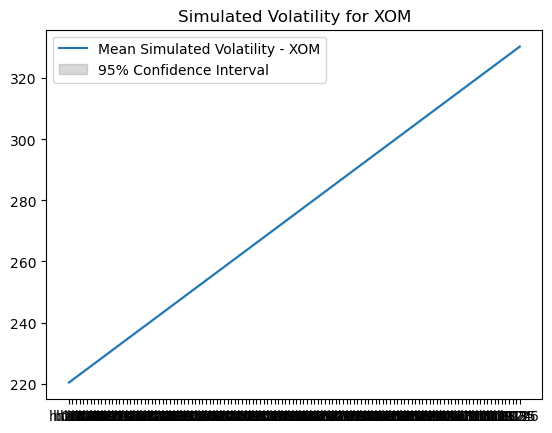

Processing GARCH for asset: COP


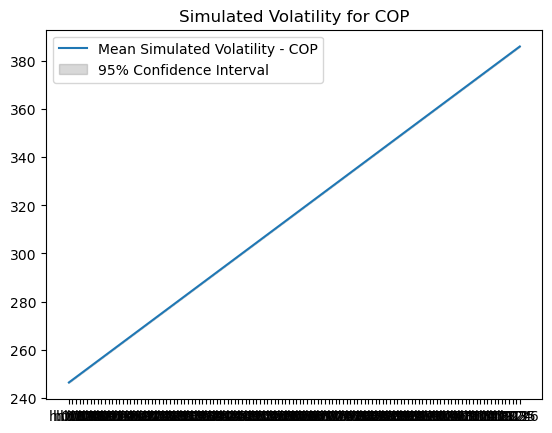

Processing GARCH for asset: XLE


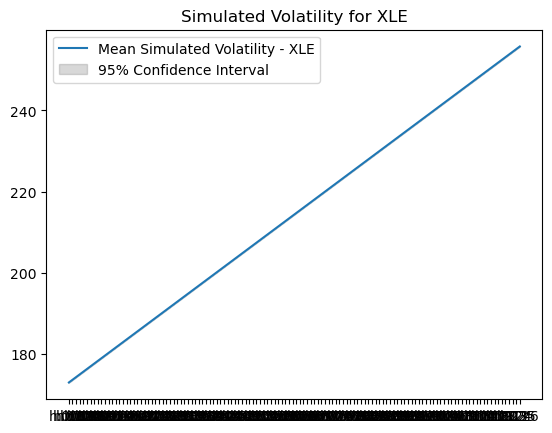

Processing GARCH for asset: SH


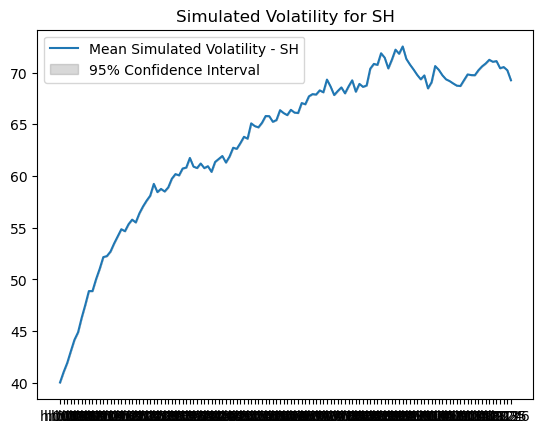

Processing GARCH for asset: FSLR


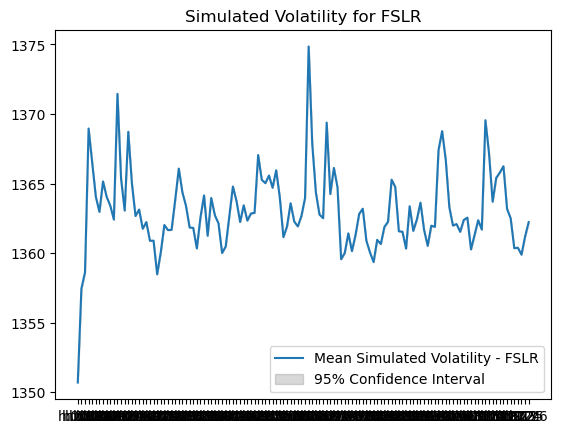

Processing GARCH for asset: BEP


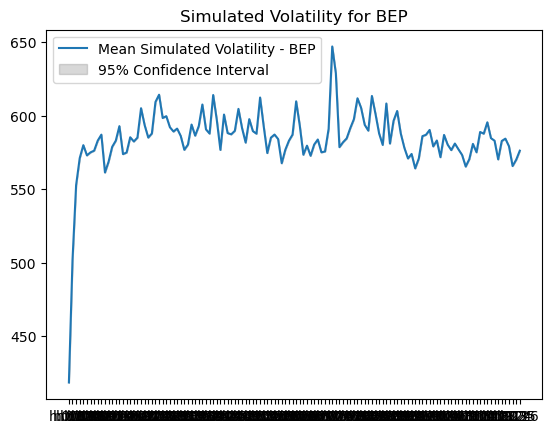

Processing GARCH for asset: CVX


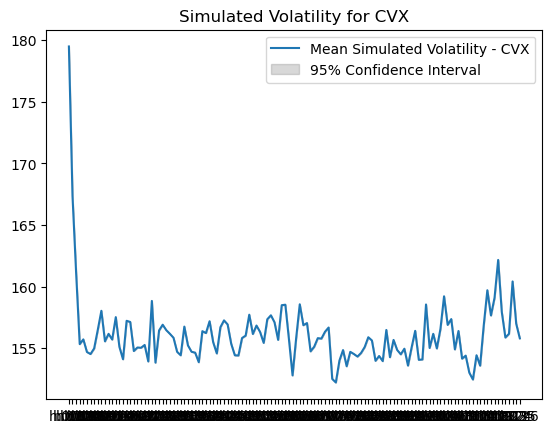

Processing GARCH for asset: ENB


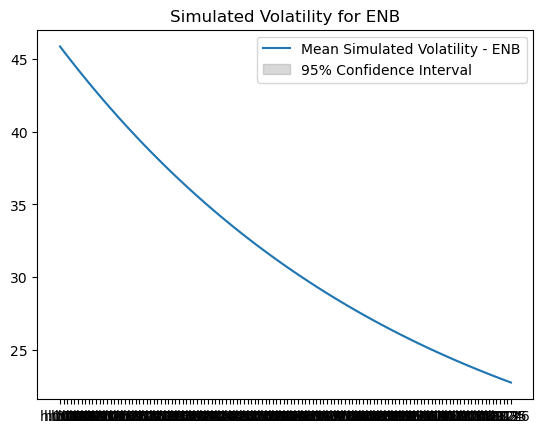

Processing GARCH for asset: ICLN


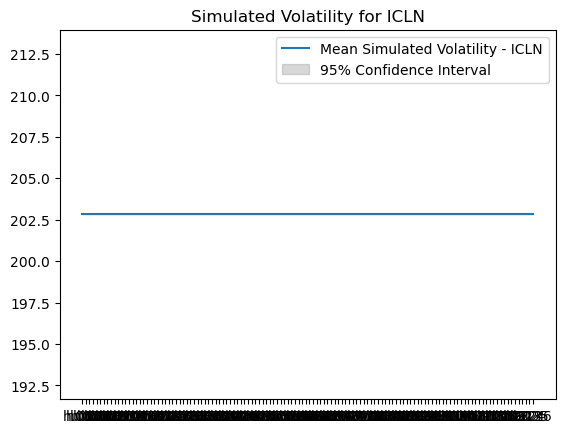

Processing GARCH for asset: NEE


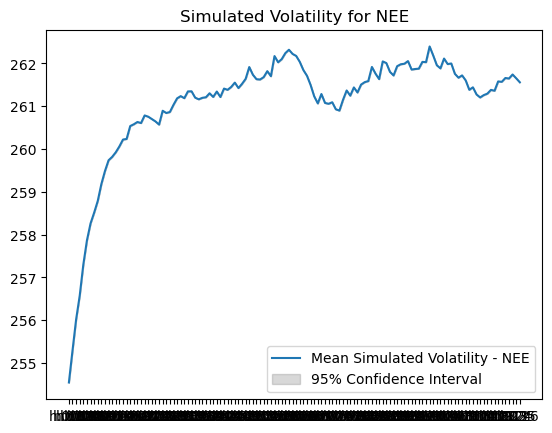

Processing GARCH for asset: CL=F


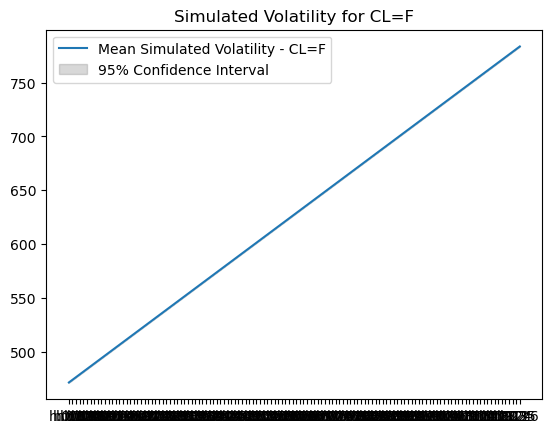

Processing GARCH for asset: NG=F


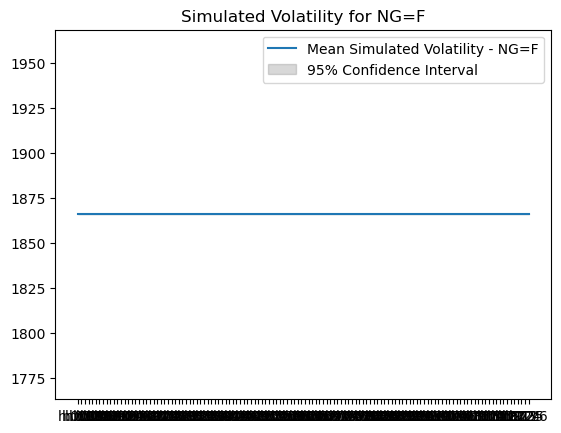

Processing GARCH for asset: SRE


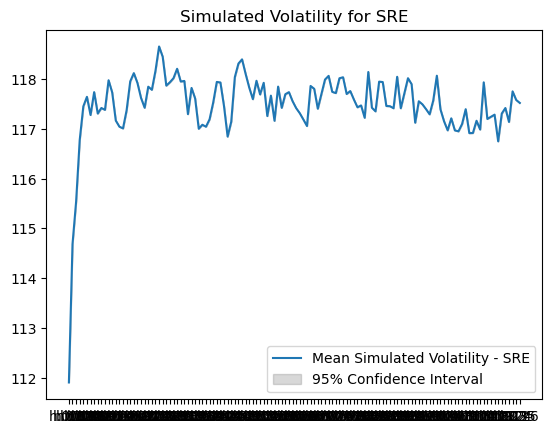

In [123]:
from arch import arch_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# List of asset tickers from `log_returns_scaled`
assets = ['XOM', 'COP', 'XLE', 'SH', 'FSLR', 'BEP', 'CVX', 'ENB', 'ICLN', 'NEE', 'CL=F', 'NG=F', 'SRE']

# Dictionary to store GARCH results for each asset
garch_results = {}

# Loop through each asset
for asset_name in assets:
    print(f"Processing GARCH for asset: {asset_name}")
    
    # Extract log returns for the asset from `log_returns_scaled`
    log_asset_returns_scaled = log_returns_scaled[asset_name].dropna()
    
    # Step 1: Fit GARCH(1,1) model with Student's t-distribution
    garch_model = arch_model(log_asset_returns_scaled, vol='Garch', p=1, q=1, dist='StudentsT')
    garch_fitted = garch_model.fit(disp='off')
    
    # Step 2: Generate conditional volatilities (simulated forecast)
    n_steps = int(252 / 2)  # Number of steps (6 months of trading days)
    forecast = garch_fitted.forecast(horizon=n_steps, method='simulation', simulations=1000)
    
    # Step 3: Extract the simulated variance paths correctly
    simulated_vols = forecast.variance.iloc[-n_steps:]  # Use iloc to properly slice the last steps
    
    # Step 4: Calculate the confidence interval (e.g., 95% CI) for volatility
    lower_bound = np.percentile(simulated_vols, 2.5, axis=0)
    upper_bound = np.percentile(simulated_vols, 97.5, axis=0)
    
    # Store results for the asset
    garch_results[asset_name] = {
        "mean_volatility": np.mean(simulated_vols, axis=0),
        "lower_bound_95CI": lower_bound,
        "upper_bound_95CI": upper_bound
    }
    
    # Step 5: Plot the simulated volatilities and confidence interval
    plt.figure()
    plt.plot(np.mean(simulated_vols, axis=0), label=f"Mean Simulated Volatility - {asset_name}")
    plt.fill_between(range(n_steps), lower_bound, upper_bound, color='gray', alpha=0.3, label="95% Confidence Interval")
    plt.legend()
    plt.title(f"Simulated Volatility for {asset_name}")
    plt.show()

# Covariance Matrix

In [143]:
# Remove SPY from log_returns_scaled and update the dataframe
log_returns_cleaned = log_returns_scaled.drop(columns=['SPY'])

# Recalculate covariance matrix without SPY
cov_matrix = log_returns_cleaned.cov().values

# Print covariance matrix for reference
print("Covariance Matrix:")
print(cov_matrix)

Covariance Matrix:
[[ 163.04614599  125.44439799  128.01630017  -16.63687853  -26.90194546
    16.55757348  120.50135338   40.24773886   17.94229853   41.36486562
   117.60824532   96.78346407   53.57028685]
 [ 125.44439799  170.64375705  130.99582471  -29.49681701   13.69806873
    26.77933201  126.09111959   26.61143894   20.08643626   20.98934211
   138.37685715   68.93653034   31.45107789]
 [ 128.01630017  130.99582471  129.71181989  -36.15419922    4.41307612
    32.15795577  128.00857833   36.98714712   28.65974216   28.2425816
   107.13733958   84.28994382   40.14179115]
 [ -16.63687853  -29.49681701  -36.15419922   70.42857718  -99.48184337
   -74.23857035  -35.36573636  -17.87321979  -58.66872963  -15.36923739
   -25.40097869  -39.77628417  -10.39629755]
 [ -26.90194546   13.69806873    4.41307612  -99.48184337 1304.57087353
   385.88131048   -3.39880758   23.21934163  386.89508122  190.65869628
    36.2728107   334.03243325   -5.06268407]
 [  16.55757348   26.77933201   32.15

# Robust Markowitz Optimization

In [145]:
import numpy as np
import cvxpy as cp

# Number of assets
n_assets = len(assets)

# Expected returns (lower bound for worst-case scenario)
expected_returns_lower = np.array([capm_results[asset]['expected_return_95CI'][0] for asset in assets])

# Covariance matrix (based on historical log returns)
cov_matrix = log_returns_cleaned.cov().values  # Make sure SPY is excluded from log_returns_cleaned

# Upper bound for volatilities (from GARCH simulation, worst-case volatility)
volatility_upper_bound = np.array([garch_results[asset]['upper_bound_95CI'] for asset in assets])

# Define portfolio weights variable as a column vector (n_assets, 1)
weights = cp.Variable((n_assets, 1))  # Reshaping weights as a column vector

# Portfolio return (conservative, based on lower bound of CAPM expected returns)
portfolio_return = expected_returns_lower @ weights

# Portfolio risk (based on worst-case volatilities and the covariance matrix)
portfolio_risk = cp.quad_form(weights, cov_matrix)

# Optimization objective: Maximize worst-case return and minimize worst-case risk
objective = cp.Maximize(portfolio_return - cp.norm(portfolio_risk))

# Constraints: Weights sum to 1, no short-selling (non-negative weights)
constraints = [cp.sum(weights) == 1, weights >= 0]

# Solve the robust optimization problem
problem = cp.Problem(objective, constraints)
problem.solve()

# Optimal portfolio weights (convert to 1D array for easier interpretation)
optimal_weights = np.array(weights.value).flatten()
print("Optimal Portfolio Weights:", optimal_weights)

Optimal Portfolio Weights: [-1.78271510e-10  3.98767442e-09  1.44727953e-01  4.99522765e-01
  4.02151908e-10  5.49209730e-03  1.80061405e-02  1.41017681e-01
  1.63862050e-01 -3.97534243e-10  2.73712791e-02 -2.03008576e-10
  3.01032473e-08]


# Validation

In [146]:
# Compute expected return of the portfolio using actual expected returns
expected_returns = np.array([capm_results[asset]['expected_return_mean'] for asset in assets])
portfolio_expected_return = np.dot(optimal_weights, expected_returns)
print("Expected Portfolio Return:", portfolio_expected_return)

# Compute portfolio risk using the covariance matrix
portfolio_variance = np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights))
portfolio_stddev = np.sqrt(portfolio_variance)
print("Portfolio Risk (Standard Deviation):", portfolio_stddev)

Expected Portfolio Return: 0.05117365986858302
Portfolio Risk (Standard Deviation): 4.007009811621751
